In [63]:
import sys
sys.path.append('..')

import utils, selex_dca, indep_sites
import adabmDCA
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling

import torch
from utils import one_hot
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

In [65]:
experiment_id = "Dop8V030"
round_ids = ["ARN", "R01", "R02N"]

device = torch.device("cpu")
dtype = torch.float64

In [66]:
sequences = [utils.sequences_from_file(experiment_id, round_id, device) for round_id in round_ids]

In [67]:
sequences_oh = [one_hot(seq).to(dtype=dtype, device=device) for seq in sequences]

In [96]:
import importlib
importlib.reload(selex_distribution)
importlib.reload(energy_models)
importlib.reload(training)
importlib.reload(sampling)

<module 'sampling' from '/home/scrotti/Aptamer2025py/sampling.py'>

In [97]:
L, q = sequences_oh[0][0].shape
k = torch.zeros(L, q, dtype=dtype, device=device)
h = torch.zeros(L, q, dtype=dtype, device=device)
J = torch.zeros(L, q, L, q, dtype=dtype, device=device)

tr = tree.Tree()
tr.add_node(-1)
tr.add_node(0)

selected_modes = torch.BoolTensor([[1],[1]]).to(device)

Ns0 = energy_models.IndepSites(k)
potts = energy_models.Potts(J, h)
indep = energy_models.IndepSites(h)
ps = selex_distribution.MultiModeDistribution(potts, normalized=False)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes)

In [98]:
batch_size = 10**6
data_loaders = [data_loading.SelexRoundDataLoader(seq_oh, batch_size=batch_size) for seq_oh in sequences_oh]
n_rounds = len(data_loaders) 

In [103]:
n_chains = 10**4

chains = training.init_chains(n_rounds, n_chains, L, q, device, dtype)
log_weights = torch.zeros(n_rounds, n_chains, device=device, dtype=dtype)

In [104]:
callbacks = [callback.ConvergenceMetricsCallback(), callback.PearsonCovarianceCallback()]

In [105]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [106]:
n_sweeps = 10
lr = 0.01
target_pearson = 1
max_epochs = 20

%lprun -f sampling._sample_metropolis training.train(model, data_loaders, total_reads, chains, n_sweeps, lr, max_epochs, target_pearson, callbacks=callbacks)

 0.00%[                               ] Epoch: 0/20 [00:00, ?it/s]

Timer unit: 1e-09 s

Total time: 105.578 s
File: /home/scrotti/Aptamer2025py/sampling.py
Function: _sample_metropolis at line 3

Line #      Hits         Time  Per Hit   % Time  Line Contents
     3                                           def _sample_metropolis(model, chains, t, n_steps, beta = 1.0):
     4        63     295265.0   4686.7      0.0      B, L, q = chains.shape
     5        63     115576.0   1834.5      0.0      device = chains.device
     6        63  178272674.0 2.83e+06      0.2      e_current = model.compute_energy_up_to_round(chains, t)
     7                                           
     8     28413   15058405.0    530.0      0.0      for _ in range(n_steps):
     9     28350 1021925216.0  36046.7      1.0          proposal_flip_indices = torch.randint(0, L, (B,), device=device)
    10     28350  868013886.0  30617.8      0.8          proposal_new_tokens = torch.randint(0, q, (B,), device=device)
    11                                                   
    12 

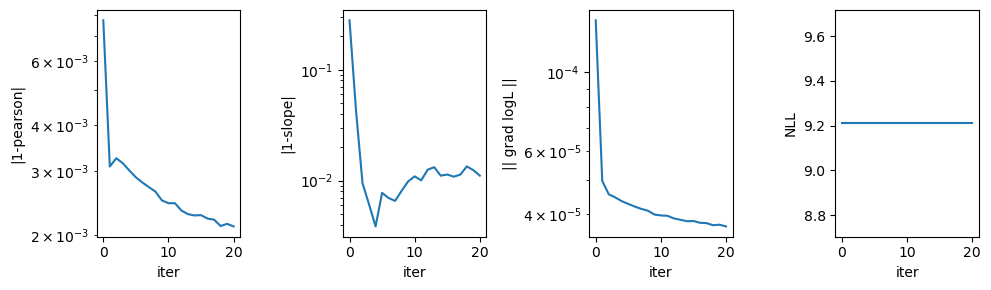

In [110]:
callbacks[0].plot();

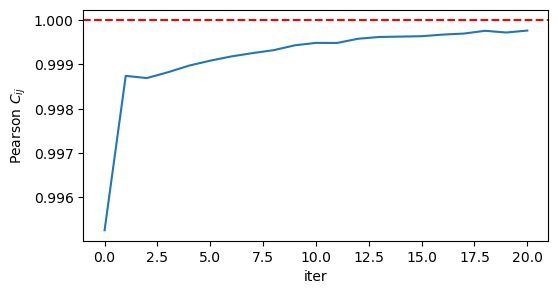

In [111]:
fig, ax = callbacks[1].plot()
ax.axhline(1, color='r', linestyle='--')

<IPython.core.display.Latex object>

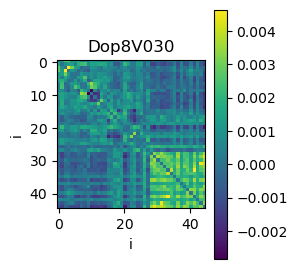

In [112]:
from IPython.display import display, Latex

potts_zerosum = potts.set_zerosum_gauge()

pl, ax = plt.subplots(figsize=(3,3))
F = selex_dca.get_contact_map(potts_zerosum.J.detach())
im = ax.imshow(F)
ax.set_xlabel("i"); ax.set_ylabel("i")
ax.set_title(experiment_id)
plt.colorbar(im)
plt.tight_layout()
# im.set_clim(-0.0015, 0.0030)
display(Latex("$F_{ij}=\\sqrt {\\sum_{ab}(J_{ij}^{ab})^2}$"))